In [1]:
import numpy as np
import pylab as pl
from math import *
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
import copy
from scipy.stats import norm
import numpy.matlib
%matplotlib inline
import h5py

Cutting the MH budget method refers to Korattikara's 2014 paper

Adaptive MH method refers to Bardenet's 2014 paper

In [2]:
# plot test result with Gaussian Mixture Model, already generated all the data, just need to load the data
# test parameters : with nsamps = 5000, minibatchsize = 100, sigma_proposer = 0.15
# number of data points = 1000,000, temperature = 10,000
'''load data '''
f2 = h5py.File('gaussianPureData.mat','r');
X = np.array(f2['data']);
f2.close()
f = h5py.File('gaussiandata.mat','r');
samples1 = np.array(f['newtestsamples'])
samples3 = np.array(f['cutmhsamples'])
samples4 = np.array(f['adaptivemhsamples'])
size1 = np.array(f['newtestsize'])
size3 = np.array(f['cutmhsize'])
size4 = np.array(f['adaptivemhsize'])
# bc1c2 = np.array(f['adaptivemhbc1c2'])
f.close()
f3 = scipy.io.loadmat('log_posterior.mat');
X_a = np.array(f3['X_a'])
Y_a = np.array(f3['Y_a'])
Z_a = np.array(f3['Z_a'])

(-3, 3)

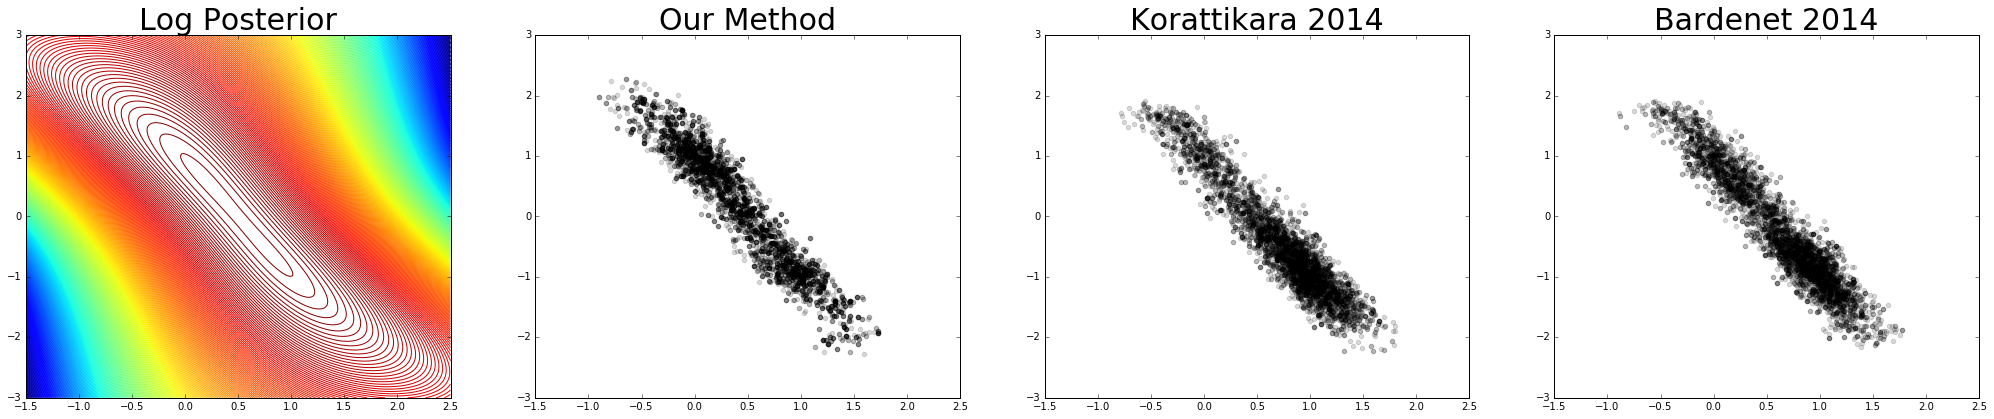

In [3]:
mymap2 = plt.get_cmap("Greys")
m_c2 = mymap2(400)

fig, axarr = plt.subplots(1,4, figsize=(35, 6.5))
axarr[0].set_title("Log Posterior", size=30)
axarr[0].contour(X_a,Y_a,Z_a,300)

# plot posterior distribution
axarr[1].set_title("Our Method", size=30)
axarr[1].scatter(samples1[:,0], samples1[:,1], color = m_c2, alpha=0.15)
axarr[1].set_xlim([-1.5,2.5])
axarr[1].set_ylim([-3,3])

axarr[2].set_title("Korattikara 2014", size=30)
axarr[2].scatter(samples3[:,0], samples3[:,1], color = m_c2, alpha=0.15)
axarr[2].set_xlim([-1.5,2.5])
axarr[2].set_ylim([-3,3])

axarr[3].set_title("Bardenet 2014", size=30)
axarr[3].scatter(samples4[:,0], samples4[:,1], color = m_c2, alpha=0.15)
axarr[3].set_xlim([-1.5,2.5])
axarr[3].set_ylim([-3,3])

# plt.savefig('../figures/GaussianMixtureResult/posterior_of_gaussian.png', dpi=600)

210.3
15562.0
16857.4
Accelerate over cut mh budget test is 73.9992370605
Accelerate over adaptive mh test is 80.1587677002


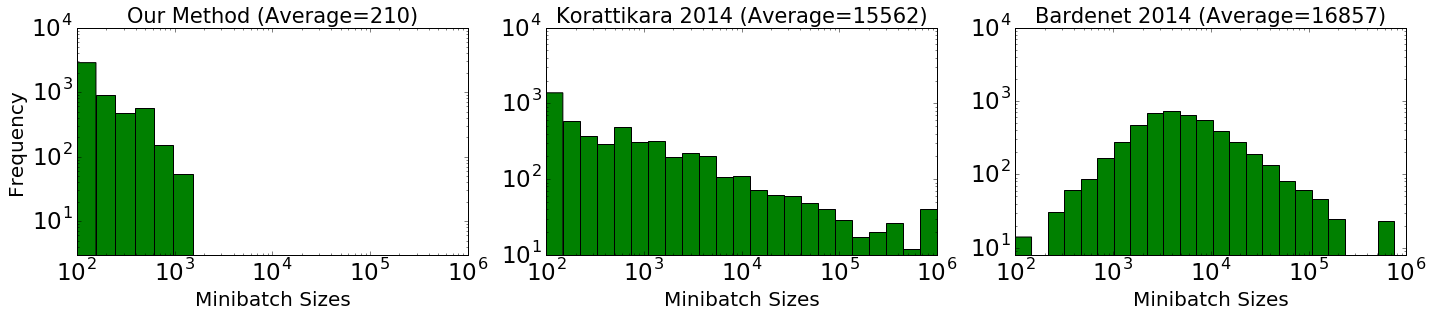

In [5]:
"""
Plot minibatch size distribution

Note: Xinlei used:

    axarr[...].hist(..., bins=np.logspace(2, 6, 25), facecolor ='green')

which is probably easier to interpret. I used an alternative method which takes 
the sizes as input but I think it's the same thing, so I'll try and simplify 
using Xinlei's method once I figure out how to use it in practice.

Oh, I also only use one y-axis label to save space (and because it should be 
obvious from context what it means).
"""

fig, axarr = plt.subplots(1,3, figsize=(20, 4.5))

# A bunch of common values. The max_y value may need some tweaking.
min_x = 10**2
max_x = 10**6
min_y = 0
max_y = 10000
yaxis_ticks = [10,100,1000,10000]
title_size = 21
axis_size = 20
tick_size = 23
fc = 'green'
x_label = "Minibatch Sizes"
y_label = "Frequency"

axarr[0].set_title("Our Method (Average=210)", fontsize=title_size)
axarr[0].hist(size1, bins=np.exp(np.linspace(np.log(np.min(size1-1)),np.log(np.max(size1+1)),8)), facecolor=fc)
axarr[0].set_xlabel(x_label, fontsize=axis_size)
axarr[0].set_ylabel(y_label, fontsize=axis_size)
axarr[0].set_xscale('log')
axarr[0].set_yscale('log')
axarr[0].set_xlim([min_x,max_x])
axarr[0].set_ylim([min_y,max_y])
axarr[0].set_yticks(yaxis_ticks)
print np.mean(size1)

axarr[1].set_title("Korattikara 2014 (Average=15562)", fontsize=title_size)
axarr[1].hist(size3, bins=np.exp(np.linspace(np.log(np.min(size3-1)),np.log(np.max(size3+1)),24)), facecolor=fc)
axarr[1].set_xlabel(x_label, fontsize=axis_size)
#axarr[1].set_ylabel(y_label, fontsize=axis_size)
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlim([min_x,max_x])
axarr[1].set_ylim([min_y,max_y])
axarr[1].set_yticks(yaxis_ticks)
print np.mean(size3)

axarr[2].set_title("Bardenet 2014 (Average=16857)", fontsize=title_size)
axarr[2].hist(size4, bins=np.exp(np.linspace(np.log(np.min(size4-1)),np.log(np.max(size4+1)),24)), facecolor=fc)
axarr[2].set_xlabel(x_label, fontsize=axis_size)
#axarr[2].set_ylabel(y_label, fontsize=axis_size)
axarr[2].set_xscale('log')
axarr[2].set_yscale('log')
axarr[2].set_xlim([min_x,max_x])
axarr[2].set_ylim([min_y,max_y])
axarr[2].set_yticks(yaxis_ticks)
print np.mean(size4)

print "Accelerate over cut mh budget test is", np.sum(size3)/np.sum(size1)*1.0
print "Accelerate over adaptive mh test is", np.sum(size4)/np.sum(size1)*1.0

plt.tight_layout()
matplotlib.rc('xtick', labelsize=tick_size) 
matplotlib.rc('ytick', labelsize=tick_size)
fig.subplots_adjust(hspace=5)
#fig.subplots_adjust(bottom=5)
# plt.savefig('../figures/GaussianMixtureResult/minibatch_size_gaussian.png', dpi=300)


In [ ]:
batch_size = bc1c2[:,0]
c1 = bc1c2[:,1]
c2 = bc1c2[:,2]

avg_c1 = np.zeros(int(np.max(batch_size)))
avg_c2 = np.zeros(int(np.max(batch_size)))
for b in range(100, int(np.max(batch_size))+1):
    index = [i for i in xrange(len(batch_size)) if batch_size[i] == b]
    if len(index) > 0:
        avg_c1[b-1] = np.mean(c1[index])
        avg_c2[b-1] = np.mean(c2[index])

In [ ]:
index = [i for i in xrange(len(avg_c1)) if ( avg_c1[i] !=0 and avg_c2[i] != 0 )]
c1_final = avg_c1[index]
c2_final = avg_c2[index]
batchsize = np.linspace(1,int(np.max(batch_size)), int(np.max(batch_size)))
batch_final = batchsize[index]

fig, axarr = plt.subplots(1,2, figsize=(19, 3))
axarr[0].set_title("First Part of Error Bound in Adaptive MH Test", size=20)
axarr[0].plot(batch_final, c1_final)
axarr[0].set_xlabel("Actual Minibatch Size", size=20)
axarr[0].set_ylabel("Value", size=20)
axarr[0].set_xscale('log')
axarr[0].set_yscale('log')
axarr[1].set_title("Second Part of Error Bound in Adaptive MH Test", size=20)
axarr[1].plot(batch_final, c2_final)
axarr[1].set_xlabel("Actual Minibatch Size", size=20)
axarr[1].set_ylabel("Value", size=20)
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
# plt.savefig('../figures/GaussianMixtureResult/first_second_part_gaussian.png', dpi=800)